In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# 选择图片
target = 1
data_name = ['0618', '0854', '1066'][target - 1]

In [3]:
# 1. 加载数据
data_path = f'../RGB_data/UniformSampler_{data_name}_3x3.csv'
data = pd.read_csv(data_path)

# 提取特征和标签
features = data.drop(columns=['Label']).values  # 去掉标签列
labels = data['Label'].values

In [4]:
#划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(features, labels,
                                                  test_size=0.25, random_state=42)

Validation dataset Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       131
           1       0.95      0.99      0.97       182

    accuracy                           0.96       313
   macro avg       0.97      0.96      0.96       313
weighted avg       0.97      0.96      0.96       313

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     53454
           1       0.94      0.98      0.96     70050

    accuracy                           0.95    123504
   macro avg       0.96      0.95      0.95    123504
weighted avg       0.95      0.95      0.95    123504

Confusion Matrix:
[[49005  4449]
 [ 1258 68792]]


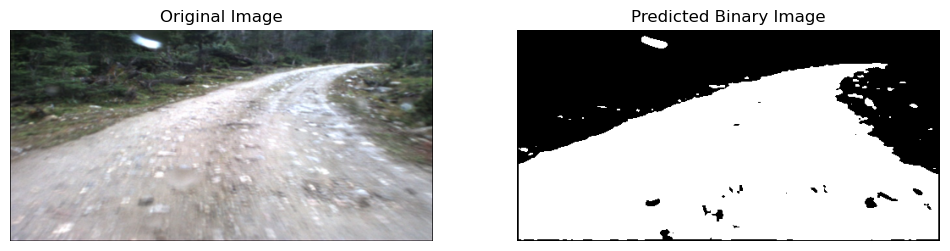

In [5]:
#训练朴素贝叶斯分类器
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#在验证集上进行预测并做评估
y_val_pred = gnb.predict(X_val)
print("Validation dataset Evaluation:")
print(classification_report(y_val, y_val_pred))

#在测试集上进行预测并评估（即对图像进行分割）
#加载原始图像作为测试集
img_path = f'../input_data/{data_name}.png'  # 修改为你的图片路径
img = cv2.imread(img_path)
height, width, _ = img.shape

# 准备特征矩阵
test_features = []

# 提取3x3块的特征
for y in range(1, height - 1):
    for x in range(1, width - 1):
        # 提取3x3区域的BGR值
        feature_vector = img[y-1:y+2, x-1:x+2].flatten()
        test_features.append(feature_vector)

# 将特征列表转换为NumPy数组
test_features_array = np.array(test_features)

#在测试集上预测
y_test_pred = gnb.predict(test_features_array)

#进行二值化并作评估
binary_path = f'../input_data/{data_name}_label.png'
binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
test_labels = binary_img[1:-1, 1:-1].flatten() // 255

# 6. 计算和打印测试集的评价指标
print("Test Set Evaluation:")
print(classification_report(test_labels, y_test_pred))

# 7. 计算混淆矩阵
conf_matrix = confusion_matrix(test_labels, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 8. 准备二值化预测图像
segmented_img = np.zeros((height, width), dtype=np.uint8)
segmented_img[1:-1, 1:-1] = y_test_pred.reshape(height - 2, width - 2) * 255  # 二值化

cv2.imwrite(f'./result_img/pred_{data_name}.png', segmented_img)

# 9. 显示原图和预测结果
plt.figure(figsize=(12, 6))

# 显示原图
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 显示预测的二值图
plt.subplot(1, 2, 2)
plt.imshow(segmented_img, cmap='gray')
plt.title('Predicted Binary Image')
plt.axis('off')

# 显示图像
plt.show()

Smoothed Image Evaluation:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     50263
           1       1.00      0.99      1.00     73241

    accuracy                           1.00    123504
   macro avg       0.99      1.00      0.99    123504
weighted avg       1.00      1.00      1.00    123504

Smoothed Confusion Matrix:
[[50263     0]
 [  612 72629]]


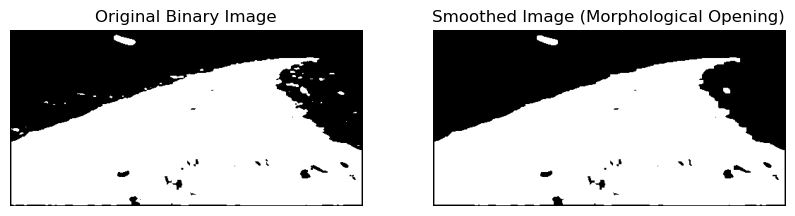

True

In [8]:
# 读取二值化图像
binary_img_path = f'./result_img/pred_{data_name}.png'  # 你的二值化图像路径
binary_img = cv2.imread(binary_img_path, cv2.IMREAD_GRAYSCALE)

# 设定结构元素大小
kernel_size = 5  # 可以根据需要调整大小
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 进行形态学开运算
smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

# 将平滑后的二值图进行评估
# 提取标签
original_labels = binary_img[1:-1, 1:-1].flatten() // 255  # 原始标签
smoothed_pred = smoothed_img[1:-1, 1:-1].flatten() // 255  # 平滑后的预测图

# 确保两个数组的长度一致
if original_labels.shape[0] != smoothed_pred.shape[0]:
    print(f"Warning: Shapes mismatch! Original: {original_labels.shape[0]}, Smoothed: {smoothed_pred.shape[0]}")

# 计算和打印平滑后的评价指标
print("Smoothed Image Evaluation:")
print(classification_report(original_labels, smoothed_pred))

# 计算混淆矩阵
smoothed_conf_matrix = confusion_matrix(original_labels, smoothed_pred)
print("Smoothed Confusion Matrix:")
print(smoothed_conf_matrix)

# 显示原始二值图与处理后的图像
plt.figure(figsize=(10, 5))

# 显示原始二值图
plt.subplot(1, 2, 1)
plt.imshow(binary_img, cmap='gray')
plt.title('Original Binary Image')
plt.axis('off')

# 显示平滑后的图像
plt.subplot(1, 2, 2)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Smoothed Image (Morphological Opening)')
plt.axis('off')

plt.show()

# 保存平滑后的图像
cv2.imwrite(f'./result_img/smoothed_pred_{data_name}.png', smoothed_img)